In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from skimage import color
from torch.utils.data import Dataset,random_split,DataLoader
import torch
import torch.nn as nn
from functools import cached_property
from tqdm import tqdm
from pathlib import Path
from shutil import rmtree
import pickle as pkl
from collections import defaultdict
import math
from typing import Callable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import random
import itertools
from sklearn.model_selection import KFold
from pathlib import Path
import tifffile as tif
import json

In [3]:
# Various paths
IN_PATH = "..\\..\\..\\..\\data\\prepro\\"
CROPPED_PATH = f"{IN_PATH}cropped\\"
SRC_1_PATH = f"{CROPPED_PATH}source1\\"
SRC_2_PATH = f"{CROPPED_PATH}source2\\"
OUT_PATH = "cnn\\"
MODEL_OUT_PATH = f"{OUT_PATH}\\models\\"

REPRO_SEED = 42
generator = torch.Generator().manual_seed(REPRO_SEED)
TEXT_SEPARATOR = "-"*80

In [4]:
assert Path(IN_PATH).exists() and Path(CROPPED_PATH).exists() and Path(SRC_1_PATH).exists() and Path(SRC_2_PATH).exists()
assert Path(IN_PATH).is_dir() and Path(CROPPED_PATH).is_dir() and Path(SRC_1_PATH).is_dir() and Path(SRC_2_PATH).is_dir()
if not Path(OUT_PATH).exists():
    Path(OUT_PATH).mkdir(parents=True, exist_ok=True)
if not Path(MODEL_OUT_PATH).exists():
    Path(MODEL_OUT_PATH).mkdir(parents=False, exist_ok=True)

In [5]:
MAPPINGS_FILE = f"{IN_PATH}manual_image_mapping.json"
assert Path(MAPPINGS_FILE).exists() and Path(MAPPINGS_FILE).is_file(),f"{Path(MAPPINGS_FILE).resolve()} does not exist"

def rel_path(path:str)->str:
    return path.replace("data\\prepro\\",IN_PATH)

def hot_patch_mappings(mappings:dict)->dict:
    for k,v in mappings.items():
        mappings[k] = [rel_path(file).replace("negative_film_tiff\\source1","cropped\\source1").replace("negative_film_tiff\\source2","cropped\\source2") if "negative_film_tiff" in file else rel_path(file) for file in v]
    return mappings

with open(MAPPINGS_FILE, "r") as f:
    mappings = hot_patch_mappings(json.load(f))

C:\Users\vesbr\Documents\EPFL\Master\MA4\Computational_Photography\positron\data\prepro\da_tiff\DSCF7040.tif


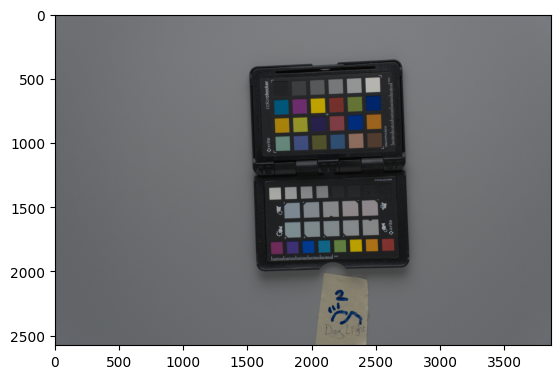

In [6]:
test_pics = mappings["1"]
test_pics
test_gt = test_pics[0]
test_src1 = test_pics[1]
print(Path(test_gt).resolve())
plt.imshow(tif.imread(Path(test_gt).resolve()))





In [7]:
COLOR_CHECKER_VALUES_D50_ILLUM = [[115,82,68],
[194,150,130],
[98,122,157],
[87,108,67],
[133,128,177],
[103,189,170],
[214,126,44],
[80,91,166],
[193,90,99],
[94,60,108],
[157,188,64],
[224,163,46],
[56,61,150],
[70,148,73],
[175,54,60],
[231,199,31],
[187,86,149],
[8,133,161],
[243,243,242],
[200,200,200],
[160,160,160],
[122,122,121],
[85,85,85],
[52,52,52]]
# From https://xritephoto.com/documents/literature/en/ColorData-1p_EN.pdf
# Assumes 2 degree observer @ D50 illuminant ; sRGB for D65

# D65 illuminant x y chromaticity coordinates are
# x = 0.31272, y = 0.32903 -->  XYZ = [95.047, 100.000, 108.883]
# From https://en.wikipedia.org/wiki/Standard_illuminant
D65_ILLUM_XYZ = np.array([95.047, 100.000, 108.883])/100

# D50 are 
# x = 0.34567 y = 0.35850 --> XYZ = [96.4212,100.000,82.51883]
# from https://www.waveformlighting.com/color-matching/what-is-d50-for-graphic-arts-printing and MATLAB's chromaticity coordinates
D50_ILLUM_XYZ = np.array([96.4212,100.000,82.51883])/100

# We have a pixel which was viewed under D50 --> to transform it as if it were viewed under D65, simply multiply by the ratio of the XYZ values (see notes)
def change_illuminant(start_illuminant_xyz:np.ndarray,end_illuminant_xyz:np.ndarray,pixel_rgb:np.ndarray)->np.ndarray:
    inital_255 = pixel_rgb.max() > 1
    pixel_rgb = pixel_rgb/255.0 if inital_255 else pixel_rgb
    out = color.xyz2rgb(color.rgb2xyz(pixel_rgb)*end_illuminant_xyz/start_illuminant_xyz)
    return 255*out if inital_255 else out

COLOR_CHECKER_VALUES_D65_ILLUM = change_illuminant(start_illuminant_xyz=D50_ILLUM_XYZ,end_illuminant_xyz=D65_ILLUM_XYZ,pixel_rgb=np.array(COLOR_CHECKER_VALUES_D50_ILLUM))

In [8]:
COLOR_CHECKER_VALUES_D65_ILLUM

array([[109.83251448,  83.14949135,  80.27744909],
       [184.3007628 , 151.9057893 , 151.20453689],
       [ 68.51940493, 124.04339341, 179.55096257],
       [ 79.35835771, 108.80778208,  80.24569767],
       [108.51780309, 130.55751098, 202.02836942],
       [ 63.43176814, 190.68574718, 196.02001363],
       [210.23956249, 127.5938781 ,  60.40455395],
       [ 31.18749563,  93.8410878 , 188.91222539],
       [187.16669659,  92.38941542, 115.23783174],
       [ 81.77638099,  62.15838213, 123.71958122],
       [149.70306125, 189.0111631 ,  84.5784434 ],
       [219.43389479, 164.44972625,  66.53228677],
       [  0.        ,  64.3434519 , 170.56620727],
       [ 55.40088403, 148.75048288,  89.13890287],
       [171.64946557,  56.60067158,  71.45286595],
       [225.79383773, 200.34459633,  60.47800371],
       [176.088931  ,  89.54233394, 170.34251565],
       [  0.        , 134.79433124, 184.14146408],
       [218.23855288, 245.91588722, 255.        ],
       [179.22821914, 202.44041

In [9]:
DF_CSV = "..\\outs\\new_color_checkers.csv"
df = pd.read_csv(DF_CSV)
df.head()

,image_id,pixel_num,y_rect,x_rect,y_raw,x_raw,DA_R,DA_G,DA_B,N1_R,N1_G,N1_B,N2_R,N2_G,N2_B
0,0,1,45,47,595,1766,46.0,49.0,45.0,196.0,207.0,111.0,103.0,170.0,92.0
1,0,1,20,37,570,1756,53.0,51.0,55.0,193.0,204.0,91.0,94.0,169.0,101.0
2,0,1,61,19,611,1738,49.0,50.0,54.0,190.0,203.0,102.0,99.0,169.0,122.0
3,0,1,5,3,555,1722,54.0,53.0,44.0,199.0,210.0,103.0,97.0,166.0,114.0
4,0,1,36,30,586,1749,43.0,45.0,50.0,189.0,204.0,93.0,97.0,170.0,124.0


In [10]:
def find_closest_color_checker_df(df,targets:list, change_illum:bool=False):
    df_img = df[df.image_id == 1]
    closest_matches = {}
    
    for i, target_color in enumerate(targets):
        min_dist = float('inf')
        best_idx = -1
        target_lab = color.rgb2lab(np.array([target_color])/255.0)[0]
        
        for idx, row in df_img.iterrows():
            pixel_color = [row.DA_R, row.DA_G, row.DA_B]
            
            pixel_lab = color.rgb2lab(change_illuminant(start_illuminant_xyz=D65_ILLUM_XYZ,end_illuminant_xyz=D50_ILLUM_XYZ,pixel_rgb=np.array([pixel_color]) if change_illum else np.array([pixel_color]))/255.0)[0]
            dist = np.sqrt(np.sum((target_lab - pixel_lab) ** 2))
            if dist < min_dist:
                min_dist = dist
                best_idx = idx    
        closest_matches[i] = best_idx
    return closest_matches

def find_closest_color_checker_image(img:np.ndarray,targets:list, change_illum:bool=False):
    assert len(img.shape) == 3,f"Image must be 2d w/ 3 channels, yet got shape {img.shape}"
    assert img.shape[2] == 3,f"Image must be RGB"
    was_255 = img.max() > 1
    img = img/255.0 if was_255 else img
    image_lab = color.rgb2lab(img)
    closest_matches = {}


    for i, target_color in enumerate(targets):
        min_dist = float('inf')
        best_idx = -1
        target_lab = color.rgb2lab(np.array([target_color])/255.0)[0]
        distances = np.sqrt(np.sum((image_lab - target_lab) ** 2,axis=2))
        print(distances.shape)
        best_idx = np.unravel_index(np.argmin(distances),distances.shape)
        closest_matches[i] = best_idx
    return closest_matches

    

def find_closest_color_checker(df_or_img:pd.DataFrame|np.ndarray,targets:list, change_illum:bool=False):
    if isinstance(df_or_img,pd.DataFrame):
        return find_closest_color_checker_df(df_or_img,targets,change_illum)
    else:
        return find_closest_color_checker_image(df_or_img,targets,change_illum)



In [18]:
def show_closest_matches(df_or_image, targets:list, matches:dict, change_illum:bool=False,title=""):
    # Calculate number of rows needed (ceil of total patches / 6 columns)
    n_rows = int(np.ceil(len(matches.keys()) / 6))
    fig, axes = plt.subplots(n_rows, 6, figsize=(15, 2.5*n_rows))
    axes = axes.flatten()
    
    # Plot all color pairs
    delta_e_values = []
    for i, ax in enumerate(axes):
        if i >= len(matches):
            ax.axis('off')  # Hide unused subplots
            continue
            
        # Create a subplot with two side-by-side patches
        target_color = np.array(targets[i])/255.0
        if isinstance(df_or_image,pd.DataFrame):
            matched_row = df_or_image.iloc[matches[i]]
            color_ = [matched_row.DA_R, matched_row.DA_G, matched_row.DA_B]
        else:
            assert isinstance(df_or_image,np.ndarray),f"df_or_image must be a pd.DataFrame or np.ndarray, yet got {type(df_or_image)}"
            print(matches[i])
            color_ = df_or_image[matches[i]].flatten()  
            was_255 = color_.max() > 1
            color_ = color_*255.0 if not was_255 else color_
            assert color_.shape[0] == 3
            
        matched_color = np.array(color_) if not change_illum else change_illuminant(start_illuminant_xyz=D65_ILLUM_XYZ,end_illuminant_xyz=D50_ILLUM_XYZ,pixel_rgb=np.array(color_))
        matched_color = matched_color/255.0

        # Calculate delta E
        target_lab = color.rgb2lab(np.array([target_color]))[0]
        matched_lab = color.rgb2lab(np.array([matched_color]))[0]
        delta_e = np.sqrt(np.sum((target_lab - matched_lab) ** 2))
        
        # Create and add the two patches side by side
        target_patch = patches.Rectangle((0, 0.5), 0.45, 0.45, facecolor=target_color)
        matched_patch = patches.Rectangle((0.55, 0.5), 0.45, 0.45, facecolor=matched_color)
        
        ax.add_patch(target_patch)
        ax.add_patch(matched_patch)
        
        # Add delta E text below patches
        ax.text(0.5, 0.2, f'ΔE={delta_e:.1f}', ha='center', va='center')
        delta_e_values.append(delta_e)
        # Configure subplot
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Finally, show at the bottom, the average delta E for all matches
    avg_delta_e = np.mean(list(delta_e for delta_e in delta_e_values))
    fig.text(0.5, -0.05, f'Average ΔE={avg_delta_e:.1f}', ha='center', va='center')

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()
    return fig,axes

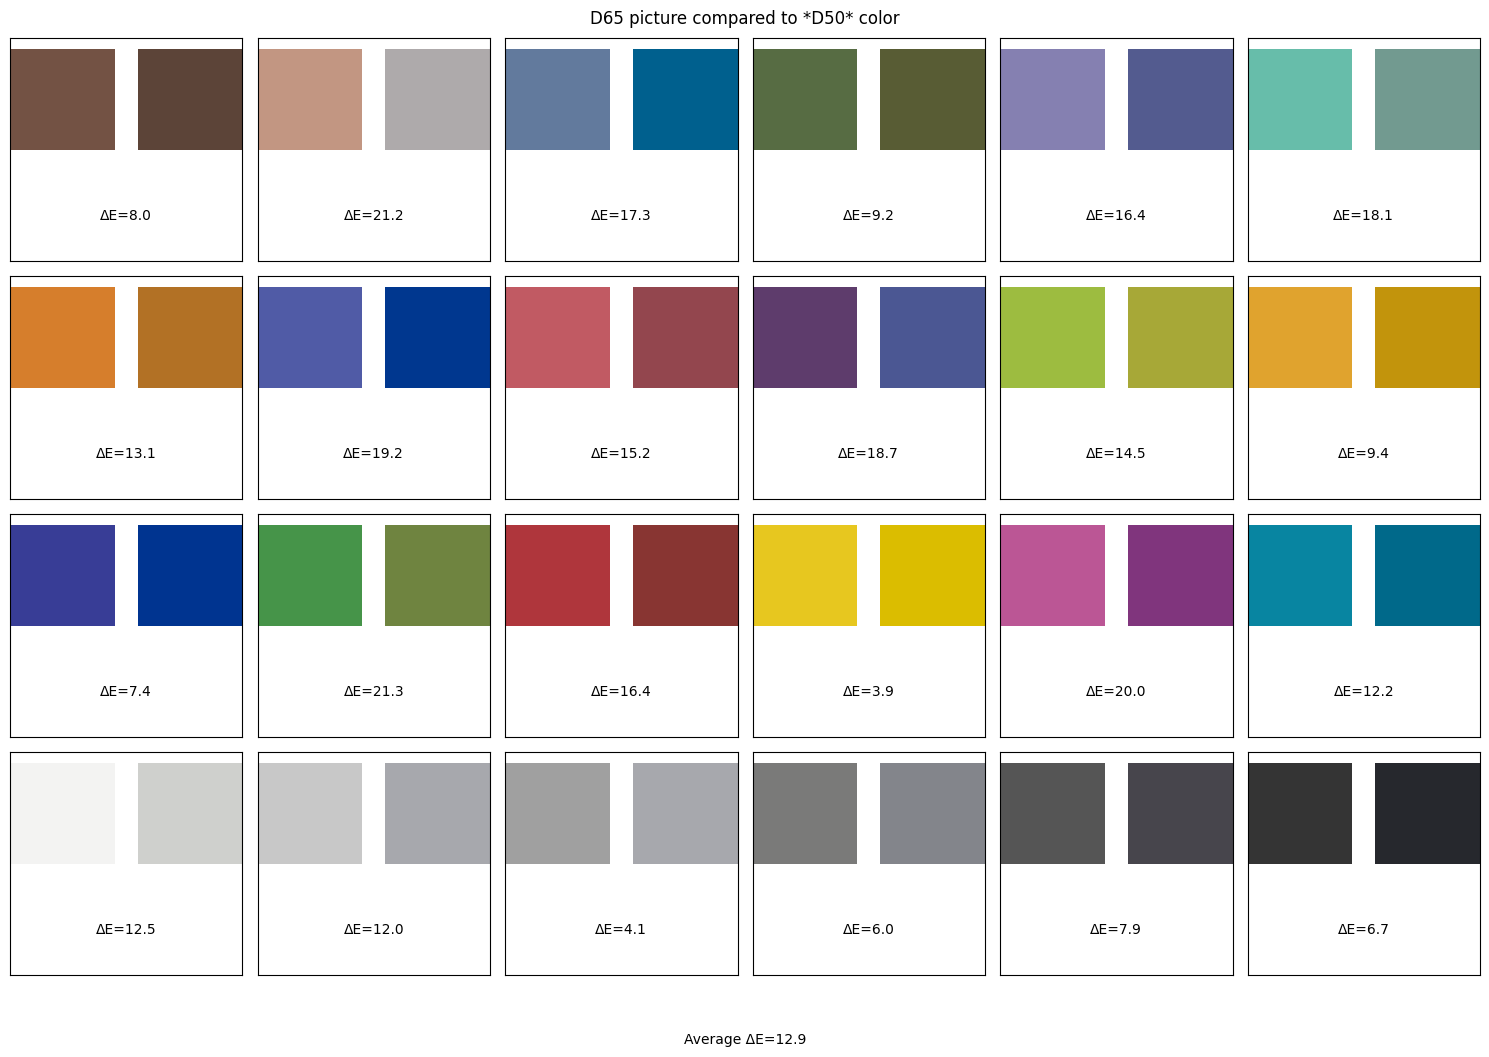

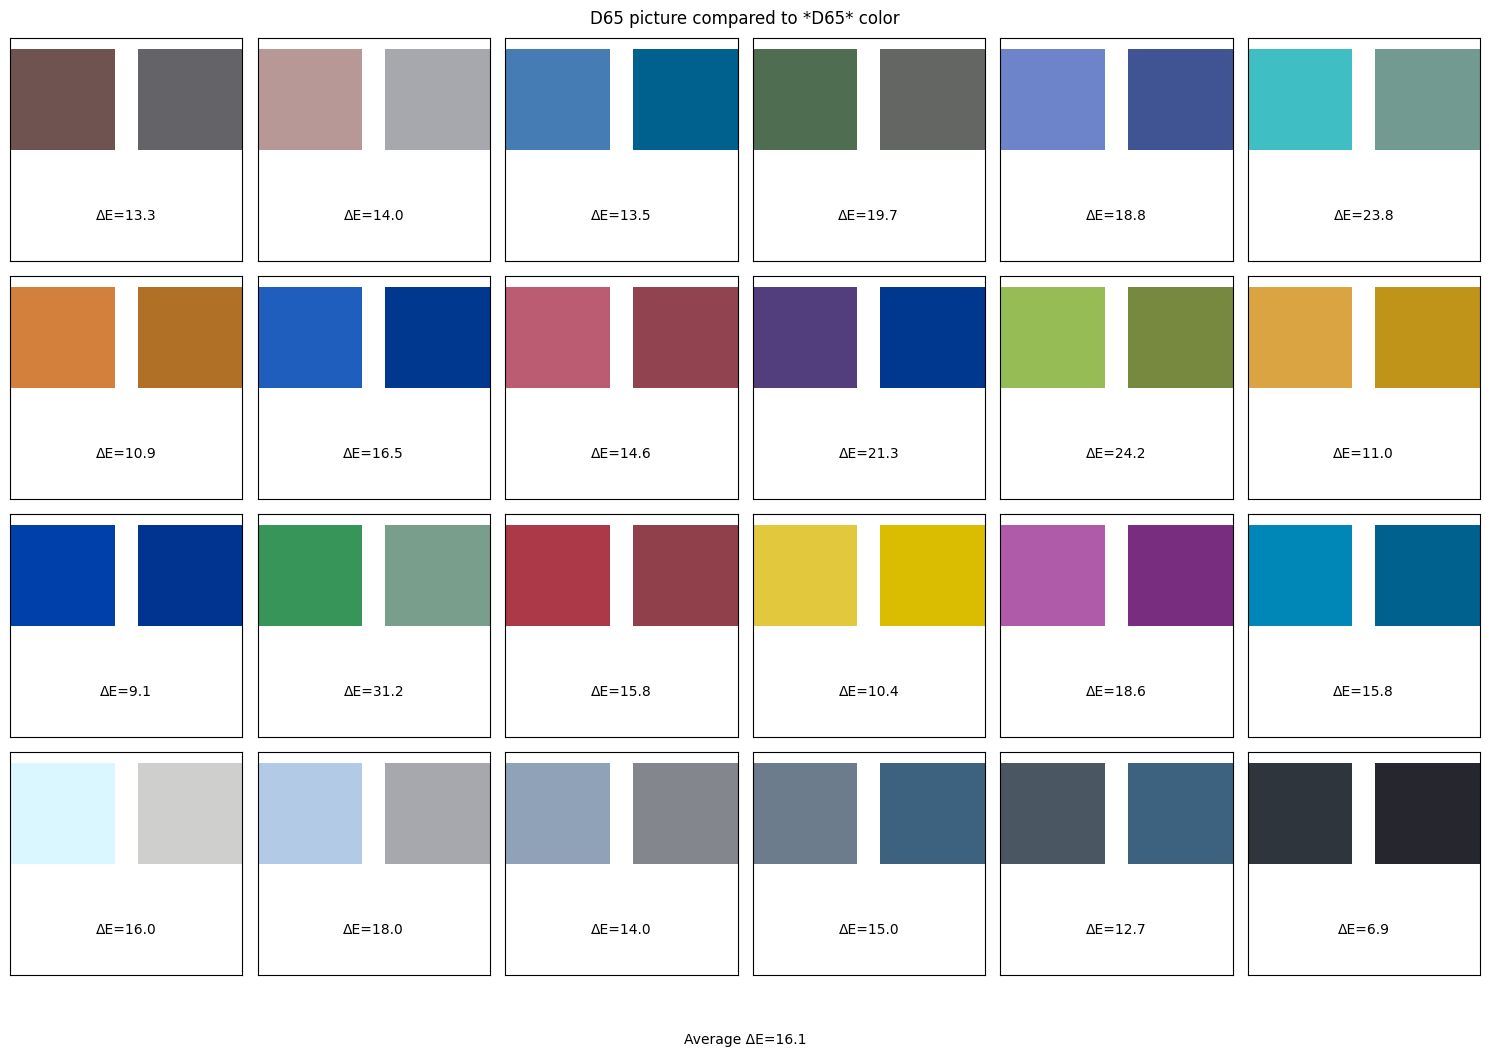

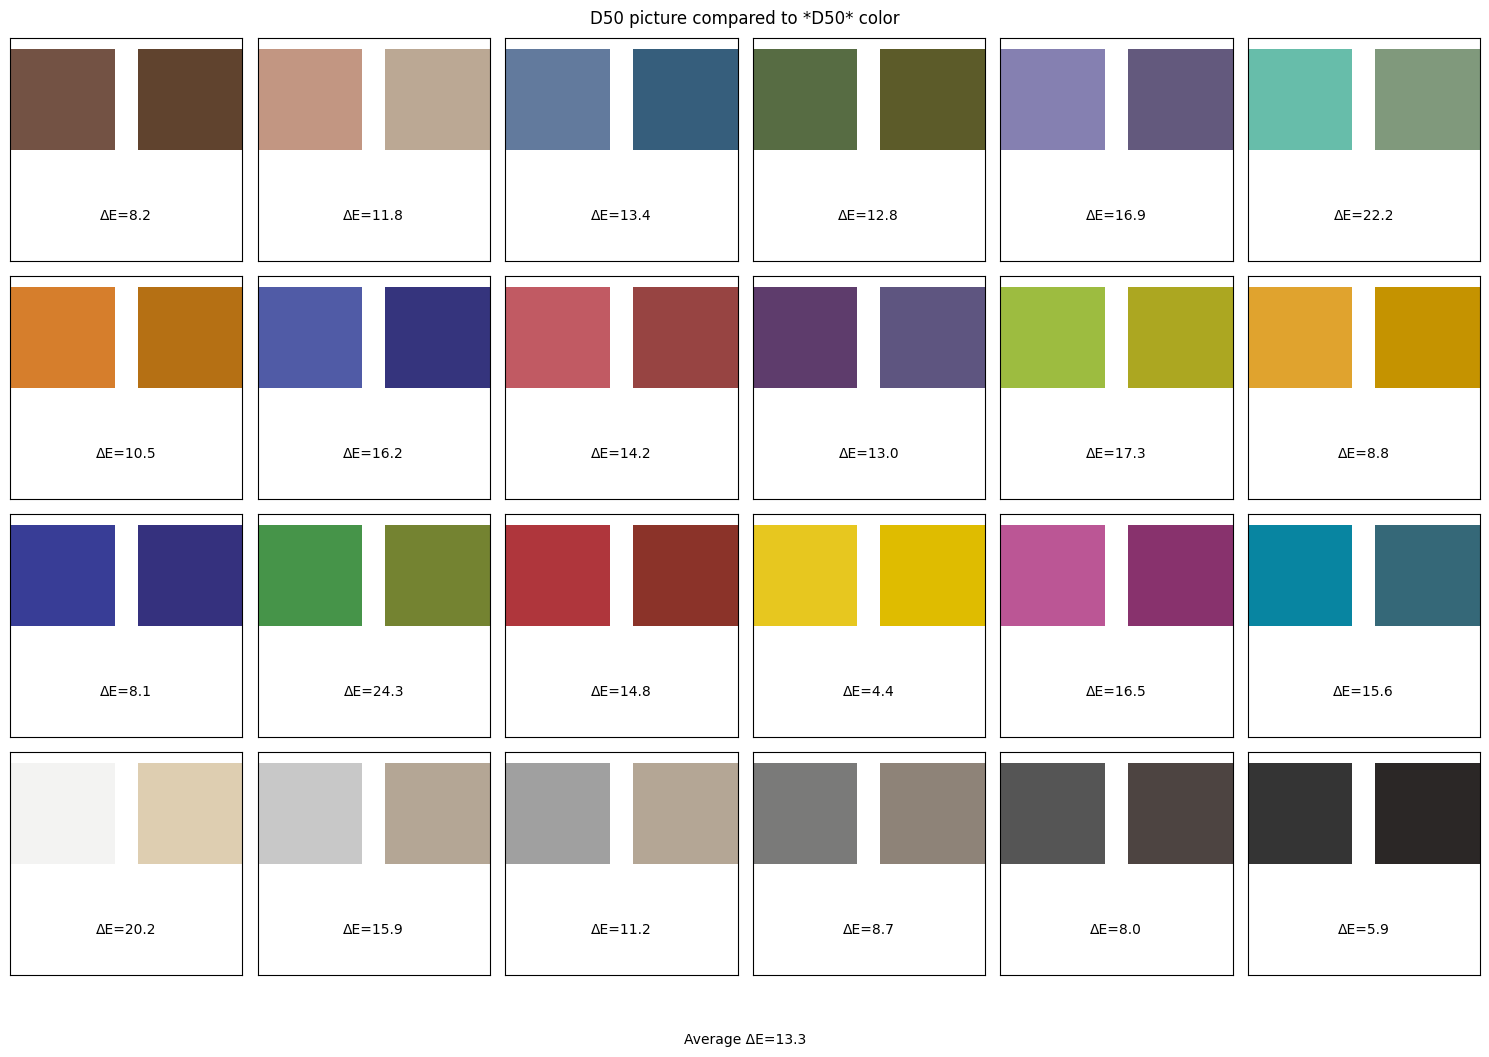

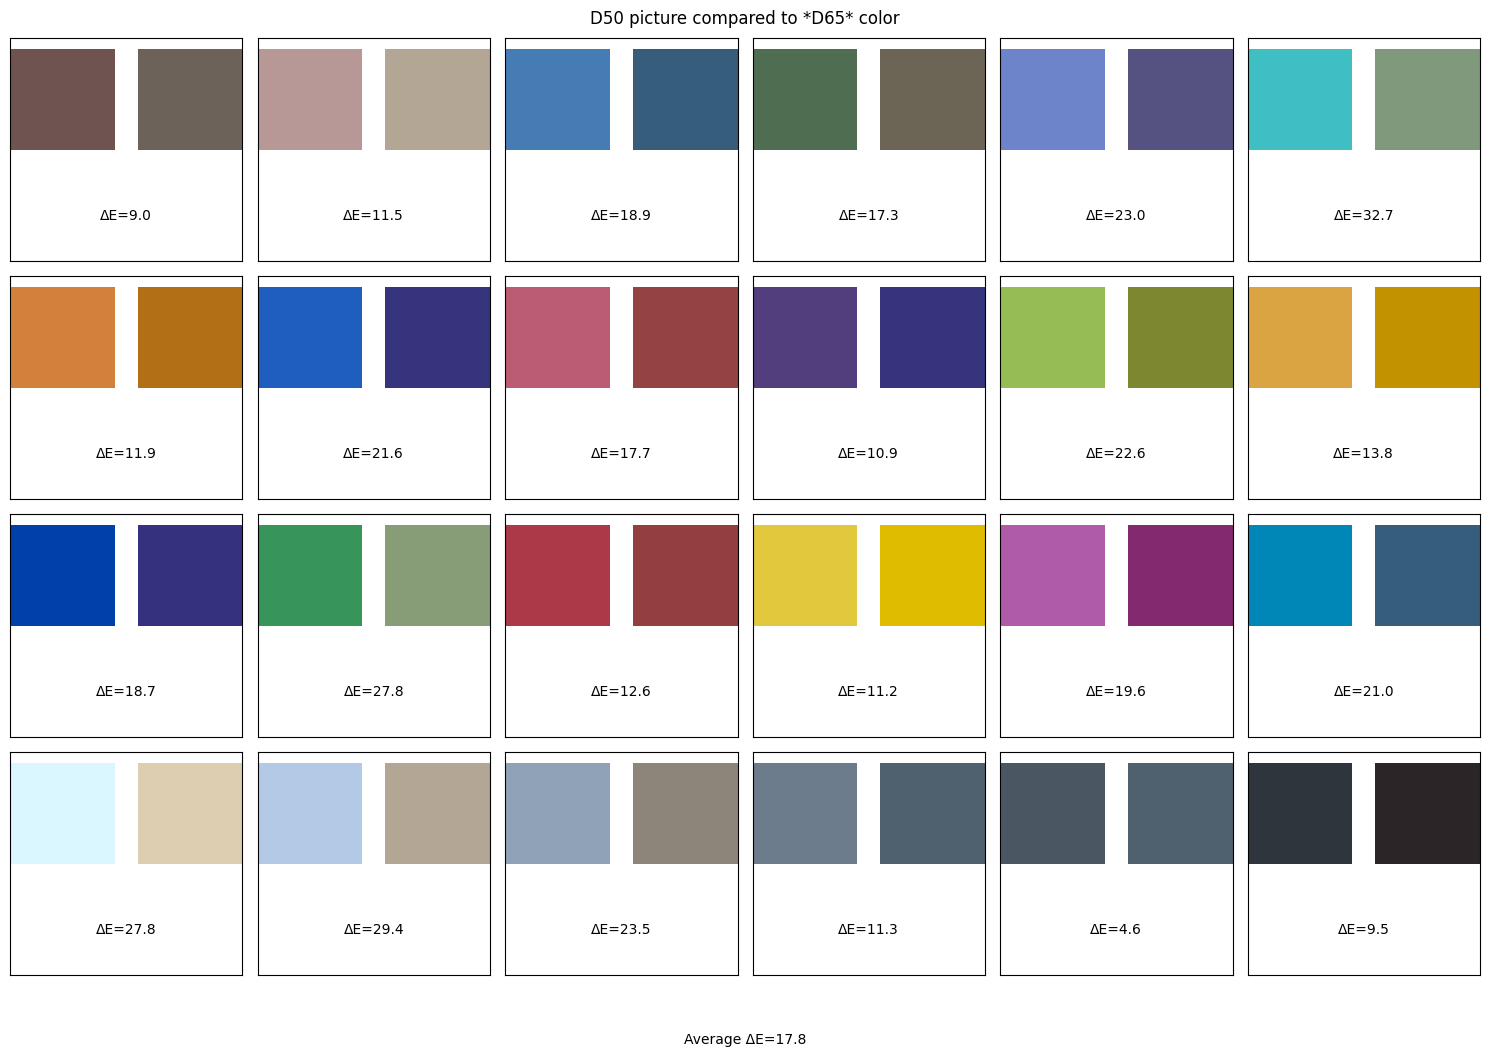

(<Figure size 1500x1000 with 24 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       dtype=object))

In [19]:
# Changing the color checker ground truths
D65_pic_D50_color = find_closest_color_checker(df,COLOR_CHECKER_VALUES_D50_ILLUM) # D65 picture comparded to D50 color
D65_pic_D65_color = find_closest_color_checker(df,COLOR_CHECKER_VALUES_D65_ILLUM) # D65 picture compared to D65 color

show_closest_matches(df,COLOR_CHECKER_VALUES_D50_ILLUM,D65_pic_D50_color,title="D65 picture compared to *D50* color")
show_closest_matches(df,COLOR_CHECKER_VALUES_D65_ILLUM,D65_pic_D65_color,title="D65 picture compared to *D65* color")

# Changing the df values
D50_pic_D50_color = find_closest_color_checker(df,COLOR_CHECKER_VALUES_D50_ILLUM,change_illum=True) # D50 picture compared to D50 color
D50_pic_D65_color = find_closest_color_checker(df,COLOR_CHECKER_VALUES_D65_ILLUM,change_illum=True) # D50 picture compared to D65 color

show_closest_matches(df,COLOR_CHECKER_VALUES_D50_ILLUM,D50_pic_D50_color,change_illum=True,title="D50 picture compared to *D50* color")
show_closest_matches(df,COLOR_CHECKER_VALUES_D65_ILLUM,D50_pic_D65_color,change_illum=True,title="D50 picture compared to *D65* color")

In [ ]:
D65_pic_D50_color

{0: 471,
 1: 284,
 2: 304,
 3: 443,
 4: 430,
 5: 428,
 6: 418,
 7: 401,
 8: 399,
 9: 431,
 10: 376,
 11: 363,
 12: 403,
 13: 342,
 14: 333,
 15: 320,
 16: 313,
 17: 303,
 18: 297,
 19: 289,
 20: 289,
 21: 278,
 22: 257,
 23: 243}